In [2]:
import h5py
import numpy as np
import pandas as pd
import tables
import os
import sys
import time
import glob
import scipy.io as sio
import hdf5_getters
from pandas import read_hdf
from musixmatch import Musixmatch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
import tensorflow as tf
from sklearn import linear_model

In [3]:
newDF = pd.read_pickle("finalLyricsData")
lyricsTokenDF = pd.read_pickle("tokenizedDF")

In [4]:
############## SET UP TOKEN VECTORIZER ##################


vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 

# use TreeankWordTokenizer

tokenizer = TreebankWordTokenizer()
vectorizer.set_params(tokenizer=tokenizer.tokenize)

# remove English stop words
vectorizer.set_params(stop_words='english')

# include 1-grams and 2-grams
vectorizer.set_params(ngram_range=(1, 2))

# ignore terms that appear in more than 50% of the documents
vectorizer.set_params(max_df=0.5)

# only keep terms that appear in at least 4 documents
vectorizer.set_params(min_df=4)

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(newDF["lyrics"])

# Numpy arrays are easy to work with, so convert the result to an 
# array
#train_data_features = train_data_features.toarray()
# see final the clean data
#print (train_data_features.shape)

In [5]:
################ DIVIDE TRAINING AND TESTING DATA
y = lyricsTokenDF['y']
x = lyricsTokenDF.drop('y', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
lyricsTokenDF.columns.values

array([0, 1, 2, ..., 4590, 4591, 'y'], dtype=object)

In [30]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ab = AdaBoostRegressor(loss='exponential')
ab.fit(x_train,y_train)
y_pred = ab.predict(x_train)
print(adjusted_mean_squared_error(y_train, y_pred))
print(mean_squared_error(y_train, y_pred))
y_predtest = ab.predict(x_test)
print(adjusted_mean_squared_error(y_test, y_predtest))
print(mean_squared_error(y_test, y_predtest))

719.4038475845069
274.3516914082688
916.5079291487382
271.2815964899217


In [11]:
def adjusted_mean_squared_error(y_true, y_predict):
    #determine MSE for each decade and then take the average
    #this helps to adjust for the fact that our dataset is heavily concentrated in 2000
    (lower, upper) = (min(y_true), max(y_true))
    y_true = np.array(y_true)
    y_predict = np.array(y_predict)
    np.reshape(y_true, (len(y_true)))
    np.reshape(y_predict, (len(y_predict)))
    decades = range(int(np.floor(lower/10)*10), int(np.floor(upper)), 10)
    mse = []
    for decade in decades:
        filter = [a >= decade and a < decade+10 for a in y_true]
        if(len(y_true[filter]) > 0):
            mse.append(mean_squared_error(y_true[filter], y_predict[filter]))
    return np.average(mse)

# type(adjusted_mean_squared_error(y_train, regRidge.predict(x_train)))

In [20]:
################ TRAIN MODELS
def scorer(estimator, X, y):
    return adjusted_mean_squared_error(y, estimator.predict(X))
regRidge = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3, scoring=scorer)
regRidge.fit(x_train, y_train)
trainMSE_ridge = adjusted_mean_squared_error(y_train, regRidge.predict(x_train))
testMSE_ridge = adjusted_mean_squared_error(y_test, regRidge.predict(x_test))

regLasso = linear_model.Lasso(alpha=0.1, scoring=scorer)
regLasso.fit(x_train, y_train)
trainMSE_lasso = adjusted_mean_squared_error(y_train, regLasso.predict(x_train))
testMSE_lasso = adjusted_mean_squared_error(y_test, regLasso.predict(x_test))

print("Ridge train: ", trainMSE_ridge, "Ridge test: ", testMSE_ridge)
print("Lasso train: ", trainMSE_lasso, "Lass test: ", testMSE_lasso)

TypeError: __init__() got an unexpected keyword argument 'scoring'

In [67]:
############## Dimension Reduction for bag of words (PCA)
from sklearn.svm import SVR

clf = SVR(gamma='scale') #SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(x_train, y_train)
print(adjusted_mean_squared_error(y_train, clf.predict(x_train)))
print(adjusted_mean_squared_error(y_test, clf.predict(x_test)))

1901.0774017593108
1344.5155415343784


In [15]:
np.sum(y_train>1990)

1473

In [15]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K

# theanofunc = theano.function([y_true, y_pred], adjusted_mean_squared_error(y_true, y_pred))
sess = tf.Session()
def custom_loss(y_true, y_pred):
    # Return a function
    return K.mean(y_pred)
#     def with_tuple(x):
# #         y = x.eval(session=sess)
# #         y_pred = y[1]
# #         y_true = y[0]
        
#         return adjusted_mean_squared_error(y_true, y_pred)
# #     return adjusted_mean_squared_error(y_true.eval(session=sess), y_pred.eval(session=sess))
#     return tf.map_fn(with_tuple, [y_true, y_pred], dtype=np.float64)

model = Sequential()
nFeat = x_train.shape[1]
model.add(Dense(1000, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(500, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(100, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss=mean_squared_error, optimizer='adam', metrics =[custom_loss])
model.fit(x_train, y_train, epochs=10, batch_size=32)
#print(mean_squared_error(y_train, model.predict(x_train)))
#print(mean_squared_error(y_test, model.predict(x_test)))

Epoch 1/10
1860/1860 [==============================] - 6s 3ms/step - loss: -2947.4538 - custom_loss: -2947.4538
Epoch 2/10
1860/1860 [==============================] - 5s 3ms/step - loss: -212394.2729 - custom_loss: -212394.2729
Epoch 3/10
1860/1860 [==============================] - 5s 3ms/step - loss: -2341612.0661 - custom_loss: -2341612.0661
Epoch 4/10
1152/1860 [=================>............] - ETA: 1s - loss: -8551116.2639 - custom_loss: -8551116.2639

KeyboardInterrupt: 

In [25]:
print(model.predict(x_train))
print(mean_squared_error(y_train, model.predict(x_train)))
print(mean_squared_error(y_test, model.predict(x_test)))

[[1946.5184]
 [1744.9718]
 [1990.0282]
 ...
 [1919.7136]
 [1989.7479]
 [2019.7651]]
14615.4120401605
381550.84935210913


In [ ]:
############## TOKENIZE TESTING DATA AND THEN MAKE PREDICTIONS
#X_test_vect = vectorizer.transform(x_test)

predicted = theModel.predict(x_test)


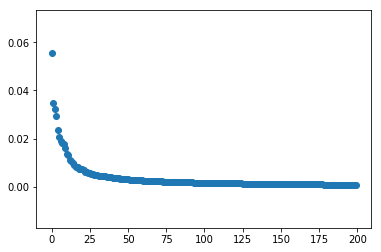

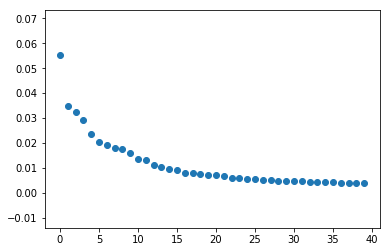

In [37]:
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
pca = PCA()
pca.fit(x)
#PCA(copy=True, iterated_power='auto', n_components=2, random_state=None, svd_solver='auto', tol=0.0, whiten=False)

plt.figure(0)
plt.scatter(np.arange(x.shape[0])[0:200], pca.explained_variance_ratio_[0:200])
plt.figure(1)
plt.scatter(np.arange(x.shape[0])[0:40], pca.explained_variance_ratio_[0:40])
# could maybe do ten?

In [56]:
# As many factors as we need to get var_ex percent of variance explained
var_ex = .9
pcaNew = PCA(var_ex)
pcaNew.fit(x)
#print(pcaNew.explained_variance_ratio_.shape)
#pcaNew.fit(x_train)
#train_img = pcaNew.transform(x_train)
#test_img = pcaNew.transform(x_test)
PCALyrics = pd.DataFrame(pcaNew.transform(x))
PCALyrics

,0,1,2,3,4,5,6,7,8,9,...,615,616,617,618,619,620,621,622,623,624
0,-2.116787,0.057054,0.472445,0.479385,0.120187,0.042785,0.085058,-0.025392,-0.082777,-0.107062,...,0.071945,-0.257032,-0.196539,0.293499,-0.090210,-0.008033,-0.063375,-0.091004,-0.023878,-0.152406
1,-1.845244,0.089885,0.100554,0.122634,-0.224908,-0.469937,0.603755,0.243914,0.095585,-0.157287,...,0.106758,-0.030016,-0.204888,-0.081121,-0.086589,0.024623,0.020169,-0.202278,-0.147184,0.137444
2,1.648525,-0.321368,-1.344397,-1.357075,-1.085122,2.695755,0.973874,0.771636,-0.046330,0.049252,...,0.041058,-0.032635,-0.087466,-0.047189,-0.054714,0.040012,-0.166939,0.152990,0.318973,-0.200929
3,-0.857782,-0.077925,-0.323338,-0.353709,-0.624141,0.113429,0.732386,0.033089,-0.159904,-0.227056,...,-0.029487,-0.151878,0.157312,-0.086829,0.024325,0.144210,-0.169575,0.266788,0.334551,0.293172
4,-1.552002,0.053533,0.702934,0.075223,-0.341615,-0.431811,0.716880,0.150989,0.704652,0.074753,...,-0.050722,-0.062439,0.067779,-0.073572,-0.116098,0.100691,0.049677,0.043782,-0.046400,0.104637
5,-0.229932,-0.371557,-0.707576,-0.738701,-0.757984,0.384194,0.092729,-0.567783,0.104021,-0.319632,...,-0.145900,0.100286,0.000739,0.013310,-0.072774,0.088626,0.122783,0.183677,-0.259670,-0.108917
6,0.005128,-0.085171,-0.923390,-0.934946,0.090286,-0.678939,-0.918403,-0.913935,0.553001,-0.440310,...,0.136758,0.125596,-0.089743,0.011098,-0.007018,-0.029027,-0.111789,-0.012239,0.004903,-0.090266
7,-1.850698,0.034082,0.145559,0.125559,-0.215341,-0.480525,0.594704,0.254327,0.123403,-0.173966,...,0.046465,0.089363,0.180623,-0.047567,0.139121,-0.042693,-0.115458,0.064821,-0.090276,-0.035782
8,-1.199715,-0.074209,0.006493,-0.288857,-0.692424,0.009445,0.678387,0.007997,-0.401786,0.756367,...,-0.151781,0.191513,0.166944,0.123518,-0.274576,0.077000,0.168240,0.077520,-0.122940,-0.146868
9,-1.399369,-0.042975,0.045395,0.009874,-0.211557,-0.447530,0.543788,0.172524,0.120550,-0.297238,...,0.098311,0.019971,-0.108096,-0.147739,-0.129239,-0.021527,-0.209052,-0.185252,-0.074520,0.110015


In [62]:
finalDataFrame = newDF.drop(["track_id","musixIndex", "lyrics"],axis=1)
finalDataFrame = finalDataFrame.set_index(np.arange(newDF.shape[0]))

In [63]:
finalDataFrame = pd.concat([finalDataFrame, PCALyrics], axis=1, sort=False)

,artist_hotttnesss,danceability,duration,end_of_fade_in,energy,key,loudness,mode,song_hotttnesss,tempo,...,615,616,617,618,619,620,621,622,623,624
0,0.434860,0.0,252.99546,0.514,0.0,1.0,-11.061,0.0,0.475638,80.084,...,0.071945,-0.257032,-0.196539,0.293499,-0.090210,-0.008033,-0.063375,-0.091004,-0.023878,-0.152406
1,0.334520,0.0,163.63057,0.000,0.0,7.0,-5.795,1.0,NaN,77.150,...,0.106758,-0.030016,-0.204888,-0.081121,-0.086589,0.024623,0.020169,-0.202278,-0.147184,0.137444
2,0.539245,0.0,216.84200,0.000,0.0,10.0,-4.264,1.0,0.788388,92.897,...,0.041058,-0.032635,-0.087466,-0.047189,-0.054714,0.040012,-0.166939,0.152990,0.318973,-0.200929
3,0.592439,0.0,218.90567,0.000,0.0,0.0,-4.707,0.0,0.681092,157.715,...,-0.029487,-0.151878,0.157312,-0.086829,0.024325,0.144210,-0.169575,0.266788,0.334551,0.293172
4,0.455559,0.0,283.48036,0.113,0.0,0.0,-4.076,0.0,0.687874,84.992,...,-0.050722,-0.062439,0.067779,-0.073572,-0.116098,0.100691,0.049677,0.043782,-0.046400,0.104637
5,0.791143,0.0,208.95302,3.245,0.0,4.0,-6.052,1.0,0.872229,105.095,...,-0.145900,0.100286,0.000739,0.013310,-0.072774,0.088626,0.122783,0.183677,-0.259670,-0.108917
6,0.578302,0.0,154.93179,0.107,0.0,5.0,-15.433,0.0,0.596841,100.042,...,0.136758,0.125596,-0.089743,0.011098,-0.007018,-0.029027,-0.111789,-0.012239,0.004903,-0.090266
7,0.481656,0.0,199.96689,0.450,0.0,5.0,-20.172,1.0,NaN,110.100,...,0.046465,0.089363,0.180623,-0.047567,0.139121,-0.042693,-0.115458,0.064821,-0.090276,-0.035782
8,0.411546,0.0,319.84281,0.000,0.0,3.0,-4.325,0.0,0.624834,92.971,...,-0.151781,0.191513,0.166944,0.123518,-0.274576,0.077000,0.168240,0.077520,-0.122940,-0.146868
9,0.459660,0.0,258.16771,0.000,0.0,11.0,-5.193,1.0,0.427447,117.936,...,0.098311,0.019971,-0.108096,-0.147739,-0.129239,-0.021527,-0.209052,-0.185252,-0.074520,0.110015


In [69]:
print(np.sum(finalDataFrame["danceability"]!=0))
print(np.sum(finalDataFrame["energy"]!=0))
#finalDataFrame["energy"]
finalDataFrame = finalDataFrame.drop(["danceability", "energy"], axis=1)

0
0


In [92]:
################# FIT MIXTURE MODELS HERE (MAYBE GAUSSIAN MIXTURE). 
################# When testing stuff you will have to make a new test and training split
from sklearn.mixture import GaussianMixture
gMM = GaussianMixture(n_components = 20)

finalDataFrame.fillna(finalDataFrame.mean(), inplace=True)

mygMM = gMM.fit_predict(finalDataFrame.drop('year',axis=1))

In [93]:
#gMM.fit(PCALyrics)

#np.sum(gMM.predict(PCALyrics)!=0)

#testDFnoLyr = newDF.drop(["danceability", "energy"], axis=1)
#testDFnoLyr.fillna(testDFnoLyr.mean(), inplace=True)
#testDFnoLyr = testDFnoLyr.drop('lyrics',axis=1)
#testDFnoLyr = testDFnoLyr.drop(["track_id","musixIndex"],axis=1)

#gMM.fit(testDFnoLyr.drop('year',axis=1))

#np.sum(gMM.predict(testDFnoLyr.drop('year',axis=1))!=0)

2205

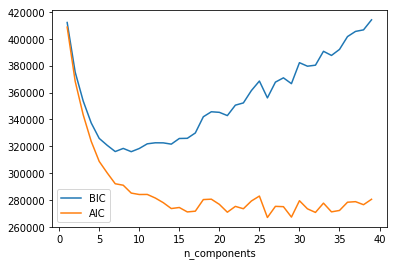

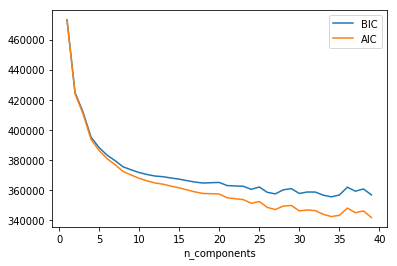

In [104]:
n_components = np.arange(1, 40)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(finalDataFrame.drop('year',axis=1))
          for n in n_components]
plt.figure(0)
plt.plot(n_components, [m.bic(finalDataFrame.drop('year',axis=1)) for m in models], label='BIC')
plt.plot(n_components, [m.aic(finalDataFrame.drop('year',axis=1)) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

# models = [GaussianMixture(n, covariance_type='diag', random_state=0).fit(finalDataFrame.drop('year',axis=1))
#           for n in n_components]
# plt.figure(1)
# plt.plot(n_components, [m.bic(finalDataFrame.drop('year',axis=1)) for m in models], label='BIC')
# plt.plot(n_components, [m.aic(finalDataFrame.drop('year',axis=1)) for m in models], label='AIC')
# plt.legend(loc='best')
# plt.xlabel('n_components');

############### LETS USE 15 LATENT COMPONENTS !!!!!!!!!!

In [106]:
from scipy.spatial.distance import pdist, squareform
def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

import scipy
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh
def eigenDecomposition(A, plot = True):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    eigenvalues, eigenvectors = eigsh(L, k=n_components, which="LM", sigma=1.0, maxiter=5000)
    
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
        plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argmax(np.diff(eigenvalues))
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

Optimal number of clusters 2


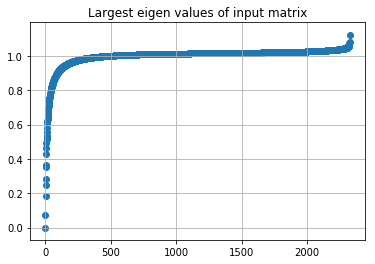

In [111]:
affinity_matrix = getAffinityMatrix(finalDataFrame.drop('year',axis=1), k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters {k}')

In [125]:
myMix1 = GaussianMixture(15, covariance_type='full')
myMix2 = GaussianMixture(30, covariance_type='full')
thePreds1 = myMix1.fit_predict(finalDataFrame.drop('year',axis=1))
thePreds2 = myMix2.fit_predict(finalDataFrame.drop('year',axis=1))

In [128]:
clusterDF1 = pd.DataFrame({"cluster": thePreds1, "year":finalDataFrame['year']})
clusterDF2 = pd.DataFrame({"cluster": thePreds2, "year":finalDataFrame['year']})
x_train_clust1, x_test_clust1, y_train_clust1, y_test_clust1 = train_test_split(clusterDF1.drop('year',axis=1), clusterDF1['year'], test_size=0.2)
x_train_clust2, x_test_clust2, y_train_clust2, y_test_clust2 = train_test_split(clusterDF1.drop('year',axis=1), clusterDF1['year'], test_size=0.2)


x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(finalDataFrame.drop('year',axis=1), finalDataFrame['year'], test_size=0.2)


In [129]:
clusterLasso = linear_model.Lasso(alpha=0.1)
clusterLasso.fit(x_train_clust1, y_train_clust1)
trainMSE_lasso_clust1 = mean_squared_error(y_train_clust1, clusterLasso.predict(x_train_clust1))
testMSE_lasso_clust1 = mean_squared_error(y_test_clust1, clusterLasso.predict(x_test_clust1))

trainMSE_lasso_clust2 = mean_squared_error(y_train_clust2, clusterLasso.predict(x_train_clust2))
testMSE_lasso_clust2 = mean_squared_error(y_test_clust2, clusterLasso.predict(x_test_clust2))

print("Orig Lasso train: ", trainMSE_lasso, "Orig Lass test: ", testMSE_lasso)
print("15 Cluster Lasso train: ", trainMSE_lasso_clust1, "15 Cluster Lass test: ", testMSE_lasso_clust1)
print("Higher Cluster Lasso train: ", trainMSE_lasso_clust2, "Higher Cluster Lass test: ", testMSE_lasso_clust2)

regLasso = linear_model.Lasso(alpha=0.1)
regLasso.fit(x_train_new, y_train_new)
trainMSE_lasso = mean_squared_error(y_train_new, regLasso.predict(x_train_new))
testMSE_lasso = mean_squared_error(y_test_new, regLasso.predict(x_test_new))

print("New Lasso train: ", trainMSE_lasso, "New Lasso test: ", testMSE_lasso)

Orig Lasso train:  118.38365463195076 Orig Lass test:  160.01664946876272
15 Cluster Lasso train:  144.04490560627372 15 Cluster Lass test:  137.0874021101292
Higher Cluster Lasso train:  140.51179324802763 Higher Cluster Lass test:  151.1895243984075
New Lasso train:  119.46016530027815 New Lasso test:  92.02223887871465


In [134]:
model = Sequential()
nFeat = x_train_clust1.shape[1]
model.add(Dense(10, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(5, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
#model.add(Dense(1, input_dim=nFeat, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train_clust1, y_train_clust1, epochs=175, batch_size=32)
print(mean_squared_error(y_train_clust1, model.predict(x_train_clust1)))
print(mean_squared_error(y_test_clust1, model.predict(x_test_clust1)))

Epoch 1/175
1860/1860 [==============================] - 0s 235us/step - loss: 3987844.9441
Epoch 2/175
1860/1860 [==============================] - 0s 25us/step - loss: 3986787.8790
Epoch 3/175
1860/1860 [==============================] - 0s 24us/step - loss: 3983188.2484
Epoch 4/175
1860/1860 [==============================] - 0s 24us/step - loss: 3974592.6989
Epoch 5/175
1860/1860 [==============================] - 0s 24us/step - loss: 3958560.0651
Epoch 6/175
1860/1860 [==============================] - 0s 24us/step - loss: 3932706.3849
Epoch 7/175
1860/1860 [==============================] - 0s 25us/step - loss: 3895449.1376
Epoch 8/175
1860/1860 [==============================] - 0s 25us/step - loss: 3844626.4699
Epoch 9/175
1860/1860 [==============================] - 0s 25us/step - loss: 3779401.5333
Epoch 10/175
1860/1860 [==============================] - 0s 24us/step - loss: 3698813.2140
Epoch 11/175
1860/1860 [==============================] - 0s 24us/step - loss: 3602516.6